In [1]:
import numpy as np
import shutil
import os
from multiprocessing import Pool
from keras.optimizers import RMSprop
from keras.losses import categorical_crossentropy
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [2]:
RND = 0
RUN = 'B5'
OUT_DIR = 'out_1m/'
TRAIN_TMP_DIR = OUT_DIR + '/train'
INPUT_DIR = '/d2/caches/tf-speech/train/audio'
TENSORBOARD_DIR = '/tensorboard/tf-speech/%s' % RUN
MODELS_DIR = '%s/models/%s' % (OUT_DIR, RUN)
INPUT_SIZE = (64, 64, 1)  # n_mels x width x 1ch
MSG_NORM_MEAN = 116.536
MSG_NORM_STD = 21.5913
LABELS = [
    'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
    'unknown', 'silence'
]

N_VAL_SAMPLES = 2500
N_TRAIN_SAMPLES = 1000000  # how many training samples to generate

In [3]:
%run 'lib.ipynb'
%run 'data-generator.ipynb'
%run 'models.ipynb'

In [4]:
# remove tensorboard data
if os.path.isdir(TENSORBOARD_DIR): shutil.rmtree(TENSORBOARD_DIR)

In [5]:
# init data gen
dg = DataGenerator(input_dir=INPUT_DIR, labels=LABELS)
dg.n_mels = INPUT_SIZE[0]
dg.msg_w = INPUT_SIZE[1]
# normalization params
dg.samplewise_norm = True
dg.msg_std = MSG_NORM_STD
dg.msg_mean = MSG_NORM_MEAN

In [6]:
# generate/load val data

val_files_path = OUT_DIR + '/val_files.npy'
val_X_path = OUT_DIR + '/val_X.npy'
val_Y_path = OUT_DIR + '/val_Y.npy'

if not os.path.isfile(val_files_path):
    # generate, save
    dg.val_files = {}
    val_X, val_Y = dg.generate_val_set(n=N_VAL_SAMPLES)
    np.save(val_files_path, dg.val_files)
    np.save(val_X_path, val_X)
    np.save(val_Y_path, val_Y)
else:
    # load
    dg.val_files = np.load(val_files_path)
    val_X = np.load(val_X_path)
    val_Y = np.load(val_Y_path)

assert len(val_X) == len(val_Y)
print('val samples: %d' % len(val_X))

val samples: 4000


In [7]:
# generate/load training data

train_X_file = '%s/train_X.npy' % OUT_DIR
train_Y_file = '%s/train_Y.npy' % OUT_DIR

if not os.path.isfile(train_X_file):
    dg.generate_train_set(
        n_total=N_TRAIN_SAMPLES,
        n_per_job=1000,
        n_pools=16,
        X_file=train_X_file,
        Y_file=train_Y_file,
        tmp_dir=TRAIN_TMP_DIR)

train_X = np.memmap(
    train_X_file, np.float32, 'r', shape=(N_TRAIN_SAMPLES, ) + INPUT_SIZE)
train_Y = np.memmap(
    train_Y_file, np.float32, 'r', shape=(N_TRAIN_SAMPLES, len(dg.labels)))

assert len(train_X) == len(train_Y)
print('training samples: %d' % len(train_X))

training samples: 1000000


In [8]:
# create model
model = Model_2(input_size=INPUT_SIZE, output_size=len(LABELS))
model.build()
optimizer = RMSprop(lr=0.0001)
model.m.compile(
    optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy']\
)

In [9]:
# create models dir
if os.path.isdir(MODELS_DIR): shutil.rmtree(MODELS_DIR)
os.makedirs(MODELS_DIR)

In [ ]:
# # train model

# N_BATCH = 500
# N_EPOCHS = 100

# model.m.fit(
#     x=train_X,
#     y=train_Y,
#     batch_size=N_BATCH,
#     epochs=N_EPOCHS,
#     verbose=1,
#     callbacks=[
#         TensorBoard(log_dir=TENSORBOARD_DIR, histogram_freq=0),
#         ModelCheckpoint(
#             MODELS_DIR +
#             '/e{epoch:03d}-l={loss:.5f}-vl={val_loss:.5f}-a={acc:.5f}-va={val_acc:.5f}.h5',
#             monitor='val_acc',
#             verbose=0,
#             save_best_only=False,
#             save_weights_only=False,
#             mode='auto'),
#         EarlyStopping(
#             monitor='val_acc',
#             min_delta=0.001,
#             patience=2,
#             verbose=1,
#             mode='auto')
#     ],
#     validation_data=(val_X, val_Y),
#     shuffle=False)

In [ ]:
# train model

N_PER_BATCH = 500
STEPS_PER_EPOCH = len(
    train_X) // N_PER_BATCH // 5  # last number splits train set into # epochs
N_EPOCHS = 100

print('# samples per epoch: %d\n' % (STEPS_PER_EPOCH * N_PER_BATCH))


def train_generator(n_per_batch):
    start_i = 0
    while True:
        if start_i >= len(train_X): start_i = 0
        batch_X = train_X[start_i:start_i + n_per_batch]
        batch_Y = train_Y[start_i:start_i + n_per_batch]
        yield (batch_X, batch_Y)
        start_i += n_per_batch


model.m.fit_generator(
    train_generator(N_PER_BATCH),
    STEPS_PER_EPOCH,
    epochs=N_EPOCHS,
    validation_data=(val_X, val_Y),
    callbacks=[
        TensorBoard(log_dir=TENSORBOARD_DIR),
        ModelCheckpoint(
            MODELS_DIR +
            '/e{epoch:03d}-l={loss:.5f}-vl={val_loss:.5f}-a={acc:.5f}-va={val_acc:.5f}.h5',
            monitor='val_acc',
            verbose=0,
            save_best_only=False,
            save_weights_only=False,
            mode='auto'),
        EarlyStopping(
            monitor='val_acc',
            min_delta=0.0001,
            patience=5,
            verbose=1,
            mode='auto')
    ])

# samples per epoch: 200000

Epoch 1/100
400/400 [==============================] - 29s - loss: 157800365360512132122416829693952.0000 - acc: 0.0792 - val_loss: 2.4847 - val_acc: 0.0907
Epoch 2/100
400/400 [==============================] - 29s - loss: 2.4869 - acc: 0.0877 - val_loss: 2.4855 - val_acc: 0.0795
Epoch 3/100
238/400 [================>.............] - ETA: 11s - loss: 2.4857 - acc: 0.0946

In [14]:
np.max(train_X)

7.6830766e+31

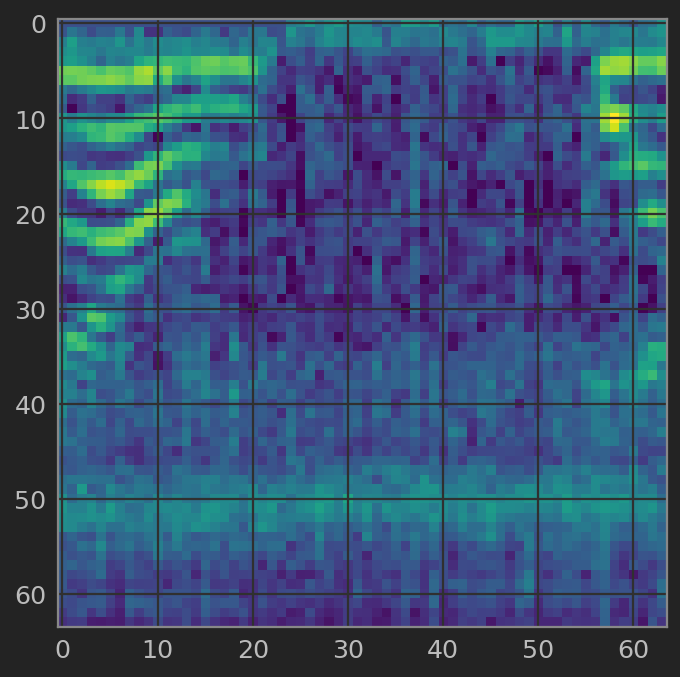

In [17]:
plt.imshow(train_X[2,:,:,0])

In [31]:
np.mean(train_X[4:5,:,:,0])

-5.3972559